In [1]:
import numpy as np
import pandas as pd
from plotly import graph_objs as go
import math
import joblib
import random
import warnings
warnings.filterwarnings(action='ignore')
random.seed(1)

In [2]:
# collecting all the target features
target_features = []
for i in range(6):
    for j in range(6):
        target_features.extend([f'x{i}{j}', f'y{i}{j}', f'z{i}{j}'])
target_features = sorted(list(set(target_features)))

# declaring the number of products available
n_prods = 5

In [3]:
# loading the scalers and trained models
saved_model_dict = {}
saved_scaler_dict = {}
for feature in target_features:
    saved_model_dict[feature] = joblib.load(f"/kaggle/input/models/kaggle/working/model_{feature}.joblib")
    saved_scaler_dict[feature] = joblib.load (f"/kaggle/input/scalers/kaggle/working/scaler_{feature}.joblib")

In [4]:
# loading the test dataset and processing it to prepare test input
df_test = pd.read_csv("/kaggle/input/df_test.csv", engine = "python")
df_test.columns = df_test.columns.str.lower()

# X_test denotes test input
X_test = df_test.drop(target_features, axis=1)

# loading the train dataset and processing it
df_train = pd.read_csv("/kaggle/input/df_train.csv", engine = "python")
df_train.columns = df_train.columns.str.lower()

# X_train denotes train input
X_train = df_train.drop(target_features, axis=1)

### Meta-heuristic optimization

In [5]:
def predict_probabilities_and_generate_risks(X):
    """
    The following function 
    1. predicts the probabilities by scaling and passing the data through the trained models
    2. generates risk related information
    """
    pred_result = {}
    for feature in target_features:
        # scaling the test data
        X_scaled = saved_scaler_dict[feature].transform(X)
        # predicting an output_feature of all the target features
        predicted_output = saved_model_dict[feature].predict(X_scaled)
        pred_result[feature] = predicted_output
    opportunity_dict = {}
    # the following weightages could be a business decision based on business's emphasis
    w1, w2, w3 = 1, 1, 1
    # the above probabilities are being combined using the above weightages below to generate opportunities.
    for i in range(6):
        for j in range(6):
            opportunity_dict[(i, j)] = w1*pred_result[f"x{i}{j}"] + w2*pred_result[f"y{i}{j}"] + w3*pred_result[f"z{i}{j}"]
    # the opportunities above are being translated into risks
    risk_dict = {}
    for i in opportunity_dict:
        risk_dict[i] = -opportunity_dict[i]
    # capsuling the information associated with a client in a dataframe for simulated annealing
    df = pd.DataFrame({
        'Data': 'X1',
        'P0': X['p0'],
        'P1': X['p1'],
        'P2': X['p2'],
        'P3': X['p3'],
        'P4': X['p4'],
        'P5': X['p5']})
    for i in range(6):
        for j in range(6):
            df[f'risk_{i}{j}'] = risk_dict[(i, j)]
    for feature in target_features:
        df[feature] = pred_result[feature]
    return df

In [6]:
def draw_graphs(best_tours, best_distances, iterations, best_distance_in_each_iteration):
    # converting each x-label into a string instead of a list i.e., transforming [1, 3, 2, 5, 4] -> '1->3->2->5->4' for ease of plotting
    transformed_tours = []
    for tour in best_tours:
        tour_string = ""
        for node in tour:
            tour_string += str(node)+"->"
        transformed_tours += [tour_string[:-2]]
    # plotting a graph with x-axis as tours and y-axis as distances.
    # the below graph shows that the best tours converge to a tour having best distance
    fig1 = go.Figure(data = go.Scatter(x= transformed_tours, y=best_distances))
    fig1.update_layout(
        title="Graph showing the convergence of best solution",
        xaxis_title="Journeys",
        yaxis_title="Risk")
    fig1.show()
    # plotting the best_distance over the course of iterations
    fig2 = go.Figure(data = go.Scatter(x=iterations, y=best_distance_in_each_iteration))
    fig2.update_layout(
        title="Graph showing the convergence of best solution with increase in iterations",
        xaxis_title="Iteration",
        yaxis_title="Risk"       
    )
    fig2.show()

def ret_cmat_prods(df):
    # Reshaping array of risks into 6*6 shape to generate risk matrix and
    # finding the products subscribed pi=1 by the customer.
    return df.iloc[0][7:7+36].values.reshape(6, 6), \
            df.iloc[0][7+36:7+(36*2)].values.reshape(6, 6), \
            df.iloc[0][7+(36*2):7+(36*3)].values.reshape(6, 6), \
            df.iloc[0][7+(36*3):7+(36*4)].values.reshape(6, 6), \
            list(np.argwhere(df.iloc[0][1:7].values==1).ravel())

def calculate_total_distance(tour, cmat, prods):
    if len(prods)==0:
        dist = cmat[0][tour[0]]
    elif len(prods)==1:
        dist = cmat[prods[0]][tour[0]]
    elif len(prods)>1:
        # calculating the sum of risks on selling tour[0] to a customer who subscribed
        # to multiple products.
        dist = 0
        for i in prods:
            temp = cmat[i][tour[0]]
            #if temp>dist:
            dist += temp
    for i in range(len(tour) - 1):
        dist += cmat[tour[i]][tour[i+1]]
    return dist

def swap(tour):
    i, j = random.sample(range(len(tour)), 2)
    tour[i], tour[j] = tour[j], tour[i]
    return tour


def adjust_tour(current_tour, metadata):
    tour = np.array(current_tour)
    tour = list(np.random.permutation(tour))
    tour.remove(metadata[0])
    tour = [metadata[0]] + tour
    if len(metadata) == 1:
        metadata = []
    else:
        metadata = metadata[1:]
    return metadata, tour


def simulated_annealing(n_prods, cmat, prods, initial_temperature=1000,
                        cooling_rate=0.99, max_iterations=100000, metadata = [], node_to_exclude = None):
    # tracking iteration count
    iteration = 0
    current_tour = list(range(0, n_prods + 1))
    if len(metadata):
        metadata, current_tour = adjust_tour(current_tour, metadata)
    if node_to_exclude is not None:
        current_tour.remove(node_to_exclude)
    # initializing a random journey
    random.shuffle(current_tour)
    # evaluating the total risk associated with the journey
    current_distance = calculate_total_distance(current_tour, cmat, prods)
    # initializing temperature
    temperature = initial_temperature
    # tracking best_tours and best_distances using lists. 
    # Initializing both of them to the initial journey and risk as they are the best known ones initially
    best_tours = [current_tour]
    best_distances = [current_distance]
    # tracking the number of iterations a best_solution is consistently seen.
    consistent_best_solution_seen_count = 1
    # tracking iterations for drawing graph
    iterations = []# for drawing graph
    # tracking best distance in each iteration to draw graph
    best_distance_in_each_iteration = []
    # the following loops exits when
    # 1. either temperature becomes less than 1
    # 2. when the iteration reaches maximum number of iterations
    # 3. when the best journey is consistently seen.
    while temperature > 1 and iteration < max_iterations:
        # creating a new random journey
        if len(metadata):
            metadata, new_tour = adjust_tour(current_tour, metadata)
        else:
            new_tour = current_tour.copy()
            random.shuffle(new_tour)
        #new_tour = swap(current_tour.copy())
        # evaluating its risk or cost
        new_distance = calculate_total_distance(new_tour, cmat, prods)
        # evaluating the change in cost
        delta_distance = new_distance - current_distance
        # Accept the new solution if the cost decreases or if the increased cost could be accepted using some probability
        if delta_distance<0 or random.random()<math.exp(-delta_distance/temperature):
            current_tour = new_tour
            current_distance = new_distance
            if current_distance < best_distances[-1]:
                # if the current journey is better than the best journey found so far, save it in the lists.
                best_tours += [current_tour]
                best_distances += [current_distance]
                # re-initialise the consistent_best_solution_seen_count
                consistent_best_solution_seen_count = 1
            else:
                # If no new best solution is found, then we increase the consistent_best_solution_seen_count by 1
                consistent_best_solution_seen_count += 1
        # tracking the following for graph
        iterations += [iteration]
        best_distance_in_each_iteration += [best_distances[-1]]
        temperature *= cooling_rate
        iteration += 1
        #if consistent_best_solution_seen_count >= 500:
        #    break
    #draw_graphs(best_tours, best_distances, iterations, best_distance_in_each_iteration)
    #print(f"Best tour: {best_tours[-1]}")
    #print(f"Number of iterations: {iteration}")
    #print(f"Final temperature: {temperature}")
    return best_tours, best_distances, iterations, best_distance_in_each_iteration, temperature

In [7]:
def predict_apply_simulated_annealing_generate_graphs(X, customer_index):
    # predict probabilities
    X = X.iloc[[customer_index]]
    df = predict_probabilities_and_generate_risks(X)
    # apply simulated annealing
    cmat, cltv_matrix, cs_matrix, ss_matrix, prods = ret_cmat_prods(df)
    high_cltv = {}
    high_cs = {}
    high_ss = {}
    least_immediate_risk = {}
    for i in prods:
        high_cltv[max(cltv_matrix[i])] = np.argmax(cltv_matrix[i])
        high_cs[max(cs_matrix[i])] = np.argmax(cs_matrix[i])
        high_ss[max(ss_matrix[i])] = np.argmax(ss_matrix[i])
        least_immediate_risk[max(cmat[i])] = np.argmin(cmat[i])
    high_cltv_prod = high_cltv[max(high_cltv.keys())]
    high_cs_prod = high_cs[max(high_cs.keys())]
    high_ss_prod = high_ss[max(high_ss.keys())]
    least_immediate_risk_prod = least_immediate_risk[max(least_immediate_risk.keys())]
    #initial_nodes = list(set([high_cltv_prod, high_cs_prod, high_ss_prod, least_immediate_risk_prod]))
    initial_nodes = list(range(n_prods+1))
    best_tours, best_distances, iterations, best_distance_in_each_iteration, temperature = simulated_annealing(n_prods, cmat, prods, metadata=initial_nodes)
    print(f"Best tour: {best_tours[-1]}")
    print(f"Number of iterations: {iterations[-1]}")
    print(f"Final temperature: {temperature}")
    # generate graphs
    draw_graphs(best_tours, best_distances, iterations, best_distance_in_each_iteration)

In [8]:
X_test.iloc[[120]]

,age,under 30,senior citizen,married,dependents,number of dependents,latitude,longitude,population,referred a friend,...,city_yorkville,city_yountville,city_yreka,city_yuba city,city_yucaipa,city_yucca valley,city_zenia,payment method_bank withdrawal,payment method_credit card,payment method_mailed check
120,40,0,0,1,0,0,38.304194,-120.592431,2718,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
predict_apply_simulated_annealing_generate_graphs(X_test, 120)

Best tour: [2, 1, 0, 5, 4, 3]
Number of iterations: 687
Final temperature: 0.9931477959208499


In [10]:
predict_apply_simulated_annealing_generate_graphs(X_test, 0)

Best tour: [3, 0, 5, 4, 2, 1]
Number of iterations: 687
Final temperature: 0.9931477959208499


In [11]:
for i in range(124, 134):
    print("index = ", i)
    predict_apply_simulated_annealing_generate_graphs(X_test, i)

index =  124
Best tour: [2, 1, 0, 5, 4, 3]
Number of iterations: 687
Final temperature: 0.9931477959208499


index =  125
Best tour: [2, 0, 5, 3, 4, 1]
Number of iterations: 687
Final temperature: 0.9931477959208499


index =  126
Best tour: [2, 0, 5, 4, 3, 1]
Number of iterations: 687
Final temperature: 0.9931477959208499


index =  127
Best tour: [1, 2, 0, 4, 5, 3]
Number of iterations: 687
Final temperature: 0.9931477959208499


index =  128
Best tour: [2, 0, 5, 4, 3, 1]
Number of iterations: 687
Final temperature: 0.9931477959208499


index =  129
Best tour: [0, 5, 4, 3, 1, 2]
Number of iterations: 687
Final temperature: 0.9931477959208499


index =  130
Best tour: [2, 1, 0, 5, 4, 3]
Number of iterations: 687
Final temperature: 0.9931477959208499


index =  131
Best tour: [1, 2, 0, 5, 4, 3]
Number of iterations: 687
Final temperature: 0.9931477959208499


index =  132
Best tour: [2, 0, 1, 4, 5, 3]
Number of iterations: 687
Final temperature: 0.9931477959208499


index =  133
Best tour: [2, 1, 0, 5, 4, 3]
Number of iterations: 687
Final temperature: 0.9931477959208499


### Performance

In [12]:
def evaluate_distances(X, customer_index):
    X = X.iloc[[customer_index]]
    df = predict_probabilities_and_generate_risks(X)
    cmat, cltv_matrix, cs_matrix, ss_matrix, prods_subscribed = ret_cmat_prods(df)
    # finding products from traditional perspective
    high_cltv = {}
    high_cs = {}
    high_ss = {}
    least_immediate_risk = {}
    for i in prods_subscribed:
        high_cltv[max(cltv_matrix[i])] = np.argmax(cltv_matrix[i])
        high_cs[max(cs_matrix[i])] = np.argmax(cs_matrix[i])
        high_ss[max(ss_matrix[i])] = np.argmax(ss_matrix[i])
        least_immediate_risk[max(cmat[i])] = np.argmin(cmat[i])
    high_cltv_prod = high_cltv[max(high_cltv.keys())]
    high_cs_prod = high_cs[max(high_cs.keys())]
    high_ss_prod = high_ss[max(high_ss.keys())]
    least_immediate_risk_prod = least_immediate_risk[max(least_immediate_risk.keys())]
    initial_nodes = list(range(0, n_prods+1))
    # applying the approach suggested as part of this thesis
    best_tours1, best_distances1, iterations1, best_distance_in_each_iteration1, temperature1 = simulated_annealing(n_prods, cmat, prods_subscribed, metadata=initial_nodes)
    recommended_prod = best_tours1[-1][0]
    distances = {'proposed': best_distances1[-1]}
    #CLTV
    if high_cltv_prod == recommended_prod:
        distances['cltv'] = best_distances1[-1]
    else:
        best_tours2, best_distances2, iterations2, best_distance_in_each_iteration2, temperature2 = simulated_annealing(n_prods, cmat, [high_cltv_prod], node_to_exclude = high_cltv_prod)
        distance_tmp = best_distances2[-1]
        for i in prods_subscribed:
            distance_tmp = cmat[i][high_cltv_prod] + distance_tmp
        distances['cltv'] = distance_tmp
    #CS
    if high_cs_prod == recommended_prod:
        distances['cs'] = best_distances1[-1]
    else:
        best_tours2, best_distances2, iterations2, best_distance_in_each_iteration2, temperature2 = simulated_annealing(n_prods, cmat, [high_cs_prod], node_to_exclude = high_cs_prod)
        distance_tmp = best_distances2[-1]
        for i in prods_subscribed:
            distance_tmp = cmat[i][high_cs_prod] + distance_tmp
        distances['cs'] = distance_tmp
    #SS
    if high_ss_prod == recommended_prod:
        distances['ss'] = best_distances1[-1]
    else:
        best_tours2, best_distances2, iterations2, best_distance_in_each_iteration2, temperature2 = simulated_annealing(n_prods, cmat, [high_ss_prod], node_to_exclude = high_ss_prod)
        distance_tmp = best_distances2[-1]
        for i in prods_subscribed:
            distance_tmp = cmat[i][high_ss_prod] + distance_tmp
        distances['ss'] = distance_tmp
    #immediate
    if least_immediate_risk_prod == recommended_prod:
        distances['immediate'] = best_distances1[-1]
    else:
        best_tours2, best_distances2, iterations2, best_distance_in_each_iteration2, temperature2 = simulated_annealing(n_prods, cmat, [least_immediate_risk_prod], node_to_exclude = least_immediate_risk_prod)
        distance_tmp = best_distances2[-1]
        for i in prods_subscribed:
            distance_tmp = cmat[i][least_immediate_risk_prod] + distance_tmp
        distances['immediate'] = distance_tmp
    # applying the approach based on the existing prediction
    return distances

In [13]:
def predict_apply_simulated_annealing_generate_sequence(X, customer_index):
    # predict probabilities
    X = X.iloc[[customer_index]]
    df = predict_probabilities_and_generate_risks(X)
    cmat, cltv_matrix, cs_matrix, ss_matrix, prods = ret_cmat_prods(df)
    # apply simulated annealing
    initial_nodes = list(range(n_prods+1))
    best_tours, best_distances, iterations, best_distance_in_each_iteration, temperature = simulated_annealing(n_prods, cmat, prods, metadata=initial_nodes)
    return best_tours[-1]

In [17]:
test_len = len(X_test)
dist = {
    'client': [],
    'proposed': [],
    'cltv': [],
    'cs': [],
    'ss' : [],
    'immediate': []
}
for i in range(test_len):
    distances = evaluate_distances(X_test, i)
    dist['client'] += [i]
    for method in distances:
        dist[method] += [distances[method]]

In [78]:
dist_df = pd.DataFrame(dist)
dist_df

,client,proposed,cltv,cs,ss,immediate
0,0,-5.959127,-5.650428,-5.959127,-5.650428,-5.793505
1,1,-6.647142,-6.647142,-6.753779,-6.753779,-6.753779
2,2,-7.768579,-7.677304,-7.677304,-7.677304,-7.677304
3,3,-7.191985,-7.191985,-7.191985,-7.191985,-6.805215
4,4,-4.329811,-3.848372,-3.930207,-3.930207,-4.225650
...,...,...,...,...,...,...
1404,1404,-5.083810,-4.371164,-4.843560,-4.371164,-4.843560
1405,1405,-12.716803,-11.899206,-11.899206,-11.899206,-11.899206
1406,1406,-5.686465,-5.596127,-5.596127,-5.596127,-5.686465
1407,1407,-8.226746,-7.851551,-8.226746,-8.226746,-7.808688


In [79]:
dist_df.to_csv(r"/kaggle/working/values.csv")

In [80]:
plot_df = dist_df.sort_values(by='proposed', ascending=False)
plot_df

,client,proposed,cltv,cs,ss,immediate
372,372,-2.261722,-2.253062,-2.253062,-2.261722,-2.253062
343,343,-2.691677,-2.568497,-2.691677,-2.691677,-2.691677
1222,1222,-2.804452,-2.804452,-2.804452,-2.773810,-2.804452
1112,1112,-2.924505,-2.897334,-2.924505,-2.924505,-2.897334
1226,1226,-2.925975,-2.939946,-2.712929,-2.925975,-2.939946
...,...,...,...,...,...,...
930,930,-17.828805,-14.477241,-17.749014,-17.749014,-17.749014
1080,1080,-18.110152,-18.088886,-14.665658,-14.665658,-18.110152
1314,1314,-18.323302,-18.066503,-14.686349,-14.686349,-18.066503
1128,1128,-18.558395,-18.334966,-14.861981,-18.334966,-15.464499


In [81]:
plot_df.to_csv(r"/kaggle/working/proposed_sorted.csv")

In [82]:
from matplotlib import pyplot as plt
y_proposed = plot_df['proposed'].values
y_cltv = plot_df['cltv'].values
y_cs = plot_df['cs'].values
y_ss = plot_df['ss'].values
y_immediate = plot_df['immediate'].values

In [83]:
import plotly.graph_objs as go
import plotly.offline as pyo


def plot_interactive_graph(label1, label2, xaxis, yaxis, title):
    x = list(range(len(plot_df)))
    y1 = plot_df[label1].values
    y2 = plot_df[label2].values
    trace1 = go.Scatter( x=x, y=y1,
        mode='lines+markers',  # 'lines', 'markers', or 'lines+markers'
        name=label1)
    trace2 = go.Scatter( x=x, y=y2,
        mode='lines+markers',
        name= label2 )
    data = [trace1, trace2]
    layout = go.Layout(
        title= title,
        xaxis=dict(title=xaxis),
        yaxis=dict(title=yaxis)
    )
    fig = go.Figure(data=data, layout=layout)
    fig.show()

def plot_interactive_scatter_graph(label1, label2, xaxis, yaxis, title):
    x = list(range(len(plot_df)))
    y1 = plot_df[label1].values
    y2 = plot_df[label2].values
    trace1 = go.Scatter( x=x, y=y1,
        mode= 'markers',
        name=label1)
    trace2 = go.Scatter( x=x, y=y2,
        mode='lines+markers',
        name= label2 )
    data = [trace1, trace2]
    layout = go.Layout(
        title= title,
        xaxis=dict(title=xaxis),
        yaxis=dict(title=yaxis)
    )
    fig = go.Figure(data=data, layout=layout)
    fig.show()

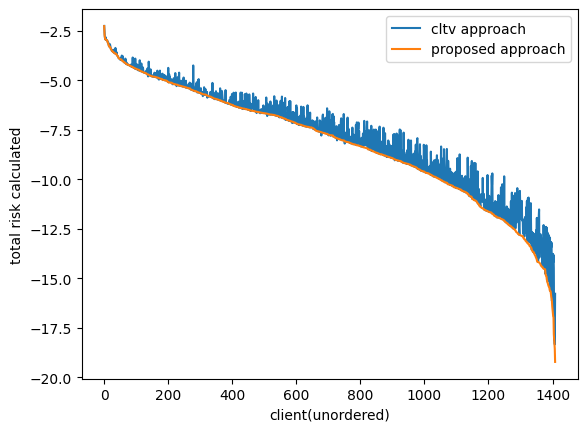

In [84]:
plt.plot(range(len(plot_df)), y_cltv, label = "cltv approach")
plt.plot(range(len(plot_df)), y_proposed, label = "proposed approach")
plt.xlabel("client(unordered)")
plt.ylabel("total risk calculated")
plt.legend(loc='best')
plt.savefig("/kaggle/working/proposed_vs_cltv.png")
plt.show()

# Interactive graph

In [85]:
xaxis = 'client(unordered)'
yaxis = 'total risk calculated'
title = ''

label1 = 'cltv'
label2 = 'proposed'

plot_interactive_graph(label1, label2, xaxis, yaxis, title)

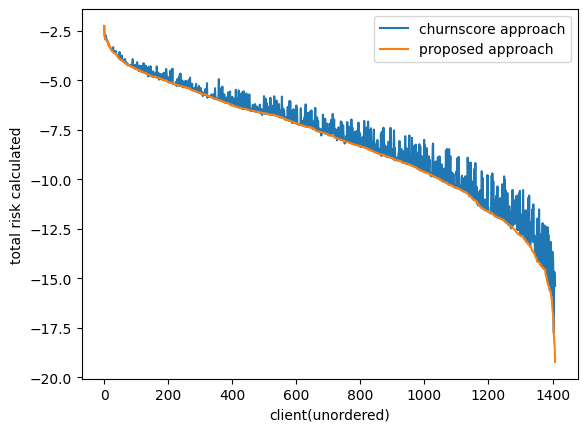

In [87]:
plt.plot(range(len(plot_df)), y_cs, label = "churnscore approach")
plt.plot(range(len(plot_df)), y_proposed, label = "proposed approach")
plt.xlabel("client(unordered)")
plt.ylabel("total risk calculated")
plt.legend(loc='best')
plt.savefig("/kaggle/working/proposed_vs_cs.png")
plt.show()


In [88]:
label1 = 'cs'
label2 = 'proposed'

plot_interactive_graph(label1, label2, xaxis, yaxis, title)

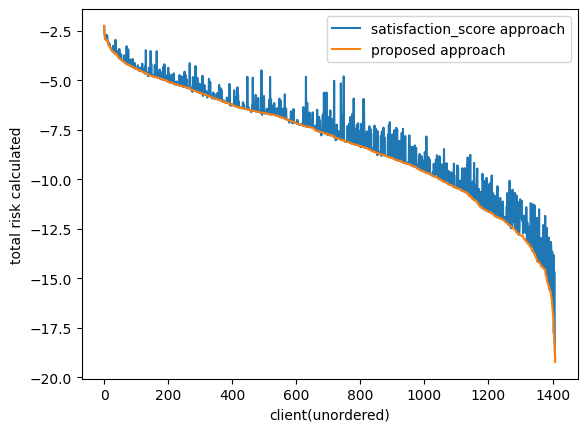

In [90]:
plt.plot(range(len(plot_df)), y_ss, label = "satisfaction_score approach")
plt.plot(range(len(plot_df)), y_proposed, label = "proposed approach")
plt.xlabel("client(unordered)")
plt.ylabel("total risk calculated")
plt.legend(loc='best')
plt.savefig("/kaggle/working/proposed_vs_ss.png")
plt.show()

In [91]:
label1 = 'ss'
label2 = 'proposed'

plot_interactive_graph(label1, label2, xaxis, yaxis, title)

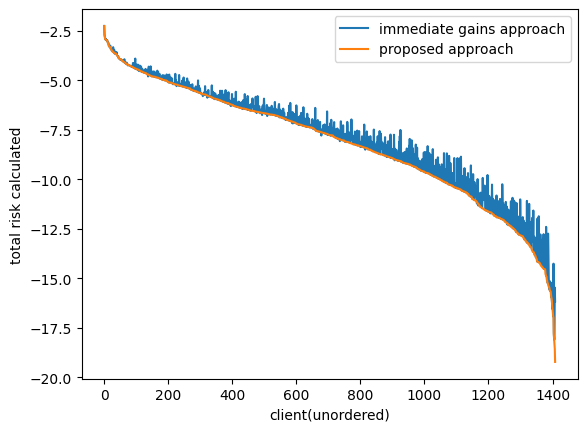

In [93]:
plt.plot(range(len(plot_df)), y_immediate, label = "immediate gains approach")
plt.plot(range(len(plot_df)), y_proposed, label = "proposed approach")
plt.xlabel("client(unordered)")
plt.ylabel("total risk calculated")
plt.legend(loc='best')
plt.savefig("/kaggle/working/proposed_vs_immediate.png")
plt.show()

In [94]:
label1 = 'immediate'
label2 = 'proposed'

plot_interactive_graph(label1, label2, xaxis, yaxis, title)

## Computing accuracies

In [96]:
proposed = dist_df['proposed'].values
cltv = dist_df['cltv'].values
cs = dist_df['cs'].values
ss = dist_df['ss'].values
immediate = dist_df['immediate'].values

In [97]:
# accuracy of predicting better than cltv approach
count_of_proposed_le_cltv = sum((proposed - cltv)<=0)
proposed_le_cltv_accuracy = count_of_proposed_le_cltv / len(dist_df)
print(f"accuracy of deriving better risk using proposed approach compared to risk computed using cltv approach : {round(proposed_le_cltv_accuracy*100, 2)}%")

accuracy of deriving better risk using proposed approach compared to risk computed using cltv approach : 97.09%


In [98]:
#accuracy of predicting better than cs approach
count_of_proposed_le_cs = sum((proposed - cs)<=0)
proposed_le_cs_accuracy = count_of_proposed_le_cs / len(dist_df)
print(f"accuracy of deriving better risk using proposed approach compared to risk computed using cs approach : {round(proposed_le_cs_accuracy*100, 2)}%")

accuracy of deriving better risk using proposed approach compared to risk computed using cs approach : 96.45%


In [99]:
#accuracy of predicting better than ss approach
count_of_proposed_le_ss = sum((proposed - ss)<=0)
proposed_le_ss_accuracy = count_of_proposed_le_ss / len(dist_df)
print(f"accuracy of deriving better risk using proposed risk compared to risk computed using ss approach : {round(proposed_le_ss_accuracy*100, 2)}%")

accuracy of deriving better risk using proposed risk compared to risk computed using ss approach : 97.02%


In [100]:
#accuracy of predicting better than immediate gains approach
count_of_proposed_le_immediate = sum((proposed - immediate)<=0)
proposed_le_immediate_accuracy = count_of_proposed_le_immediate / len(dist_df)
print(f"accuracy of deriving better risk using proposed approach compared to risk computed using immediate gains approach : {round(proposed_le_immediate_accuracy*100, 2)}%")

accuracy of deriving better risk using proposed approach compared to risk computed using immediate gains approach : 95.88%
